# Texture Analysis

## Part A

### Objective

The goal of this part is to segment the following photo into 3 segments: 
1. a segment for clothes with a jeans texture
2. a segment for clothes with a cotton texture
3. a segment for the background

<img src='test.jpg' width=100px heigth=300px></img>

In [1]:
from skimage.feature import greycomatrix, greycoprops
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np

import os

## Section 1

In this section, we will extract features from image samples of the jeans and cotton texture using GLCM, then we will plot our feature space to see if our features are able to differentiate between the textures of jeans, cotton, and background. 

In [2]:
def get_glcm_features(gray_scale_img):
    """
    Given a grayscale image with graylevels from 0 - 255, this function returns the contrast
    and the homogeneity features of the image with the help of GLCM
    """
    glcm = greycomatrix(gray_scale_img, distances=[1], angles=[0], levels=256)
    contrast = greycoprops(glcm, prop='contrast')
    homogeneity = greycoprops(glcm, prop='homogeneity')
    
    return contrast, homogeneity

In [3]:
def get_fname_images_tuple(directory):
    """
    Returns a tuple of the filenames of the images in the given directory
    """
    
    files = os.listdir(directory)
    images = []
    for filename in files:
        if filename[-3:] == 'jpg':
            path = os.path.join(directory, filename)
            gray_scale_image = (rgb2gray(io.imread(path)) * 255).astype(np.uint8)
            images.append((filename, gray_scale_image))
        else:
            print('This file has been skipped', filename)
            
    return images

In [4]:
def plot_2d_features_with_names(names_fts_list, xlabel, ylabel):
    """
    Plot the 2D features of the images in the given list
    """
    x = [names_fts[1][0] for names_fts in names_fts_list]
    y = [names_fts[1][1] for names_fts in names_fts_list]
    txts = [names_fts[0] for names_fts in names_fts_list]
    
    fig, ax = plt.subplots()
    ax.scatter(x, y)

    for i, txt in enumerate(txts):
        ax.annotate('', (x[i], y[i]))
    
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig = plt.gcf()
    fig.set_size_inches(13, 8)

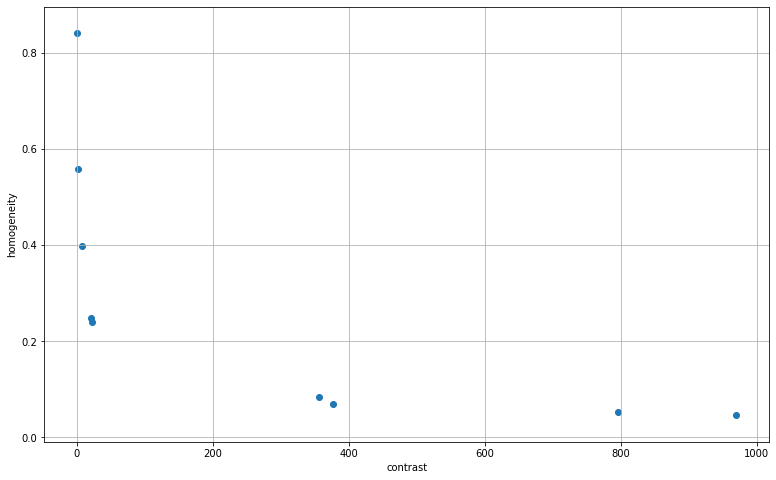

In [5]:
image_files = get_fname_images_tuple('./imgs_patches')

filename_features_list = []
for fn, img in image_files:
    filename_features_list.append((fn, get_glcm_features(img)))
    
plot_2d_features_with_names(filename_features_list, 'contrast', 'homogeneity')

## Section 2

In this section, we will classify an unknown patch into one of those categories using a simple rule-based classifier. This will make us able to segment an image.

In [6]:
def classify_patch(contrast, homogeneity):
    """
    Given the contrast and homogeneity values of a certain image patch, this function 
    will return the class of the patch, i.e either 'jeans', 'cotton', or 'background'
    """
    if contrast < 200 and homogeneity < 0.7:
        return 'cotton'
    elif contrast < 200 and homogeneity >= 0.7:
        return 'background'
    else:
        return 'jeans'


In [7]:
def segment_img(image):
    img = image.copy()
    patch_height = patch_width = 50
    
    # loop on the image patch by patch
    for i in range(patch_height, image.shape[0], patch_height):
        for j in range(patch_width, image.shape[1], patch_width):
    
            patch = img[i-patch_height:i, j-patch_width:j]
            
            patch_grayscale = (rgb2gray(patch) * 255).astype(np.uint8)
            
            contrast, homogeneity = get_glcm_features(patch_grayscale)
            classification = classify_patch(contrast, homogeneity)
            
            if classification == 'cotton':
                patch[:,:, 0] = 255
            elif classification == 'jeans':
                patch[:,:, 1] = 255
            else:
                patch[:,:,2] = 255
                
    return img

In [8]:
def segment_img(image):
    segmented_img = image.copy()
    patch_height = patch_width = 50
    
    # loop on the image patch by patch
    for i in range(patch_height, image.shape[0], patch_height):
        for j in range(patch_width, image.shape[1], patch_width):
    
            # get the patch features
            patch = segmented_img[i-patch_height:i, j-patch_width:j]            
            patch_grayscale = (rgb2gray(patch) * 255).astype(np.uint8)
            contrast, homogeneity = get_glcm_features(patch_grayscale)
            
            # classify the patch
            classification = classify_patch(contrast, homogeneity)
            
            # draw the patch on the segmented image
            if classification == 'cotton':
                patch[:,:, 0] = 255
            elif classification == 'jeans':
                patch[:,:, 1] = 255
            else:
                patch[:,:,2] = 255
                
    return segmented_img

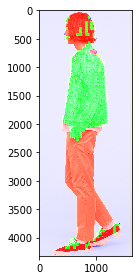

In [9]:
image = io.imread('test.jpg')
segmented_image = segment_img(image)
io.imshow(segmented_image)

## Part B

We will implement our own function that computes the LBP histogram of a grayscale image

In [10]:
def get_lbp_hist(grayscale_img):
    """
    Returns the LBP histogram of the given grayscale image
    It uses the radius of 1, the number of points to consider as 8
    """
    lbp_hist=np.zeros(256)
    
    for i in range(1,grayscale_img.shape[0]-1):
        for j in range(1,grayscale_img.shape[1]-1):
            number = 0
            center = grayscale_img[i,j]
            
            if grayscale_img[i-1, j-1] > center: number += 128
            if grayscale_img[i-1, j] > center: number += 64
            if grayscale_img[i-1, j+1] > center: number += 32
            if grayscale_img[i, j+1] > center: number += 16
            if grayscale_img[i+1, j+1] > center: number += 8
            if grayscale_img[i+1, j] > center: number += 4
            if grayscale_img[i+1, j-1] > center: number += 2
            if grayscale_img[i, j-1] > center: number += 1
            
            lbp_hist[number] += 1
            
    return lbp_hist 

'ignore function output'

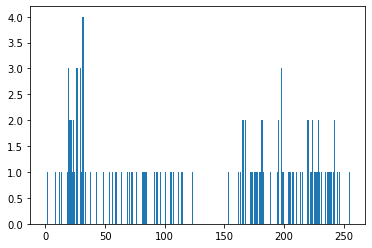

In [11]:
# get the histogram of the jeans image
img = rgb2gray(io.imread('./imgs_patches/jeans1.jpg'))
hist = get_lbp_hist(img)
plt.hist(hist, bins=range((2 ** 8)))
'ignore function output'

'ignore function output'

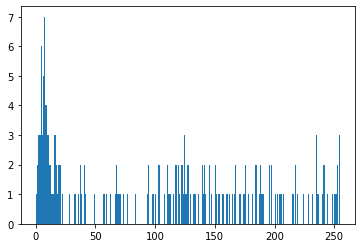

In [12]:
# get the histogram of the cotton image
img = rgb2gray(io.imread('./imgs_patches/cotton1.jpg'))
hist = get_lbp_hist(img)
plt.hist(hist, bins=range((2 ** 8)))
'ignore function output'

As we can see there is a noticable difference between the histograms of jeans and cotton